# Notebook to explore Gaia DR3 data
author: [Mathieu Renzo](mrenzo@flatironinstitute.org)

In [39]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astroquery.gaia import Gaia
from astropy.io import fits
from astropy.wcs import WCS
import aplpy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Orion nebula

We want to visualize real images of the region for intuition.
`Fits` images from [Noirlab](https://noirlab.edu/public/products/education/edu024/)

In [45]:
# create stacked IR+optical image, IR shows the gas, optical shows the stars
fits_files = glob.glob(str(os.getcwd())+'/orion/edu024/*.fits') # hack
print(fits_files)
image_concat = [fits.getdata(image) for image in fits_files]
stacked = np.zeros(shape=image_concat[0].shape)
for image in image_concat:
    stacked += image

['/home/math/Documents/Outreach/MfA_workshop_runaways/playground/orion/edu024/m42_40min_ir.fits', '/home/math/Documents/Outreach/MfA_workshop_runaways/playground/orion/edu024/m42_40min_red.fits']


In [23]:
# show fits header -- explains what is in the fits file
hdul = fits.open(fits_files[1])
#print(hdul[0].header)
# get world coordinate system (wcs) from image
wcs = WCS(hdul[0].header)
# get center of that image
orion_im_ra = Angle(hdul[0].header["OBJCTRA"], unit=u.hourangle).to(u.degree)
orion_im_dec = Angle(hdul[0].header["OBJCTDEC"], unit=u.deg).to(u.degree)
print(orion_im_ra.to(u.deg), orion_im_dec.to(u.deg))

83d49m18s -5d23m27.9s


 [astropy.io.fits.verify]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
Changed DATE-OBS from '1990/12/22        ' to '1990-12-22T00:00:00.0''. [astropy.wcs.wcs]


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
Changed DATE-OBS from '1996/01/27        ' to '1996-01-27T00:00:00.0''. [astropy.wcs.wcs]


INFO: Auto-setting vmin to  1.603e+03 [aplpy.core]
INFO: Auto-setting vmax to  2.786e+04 [aplpy.core]


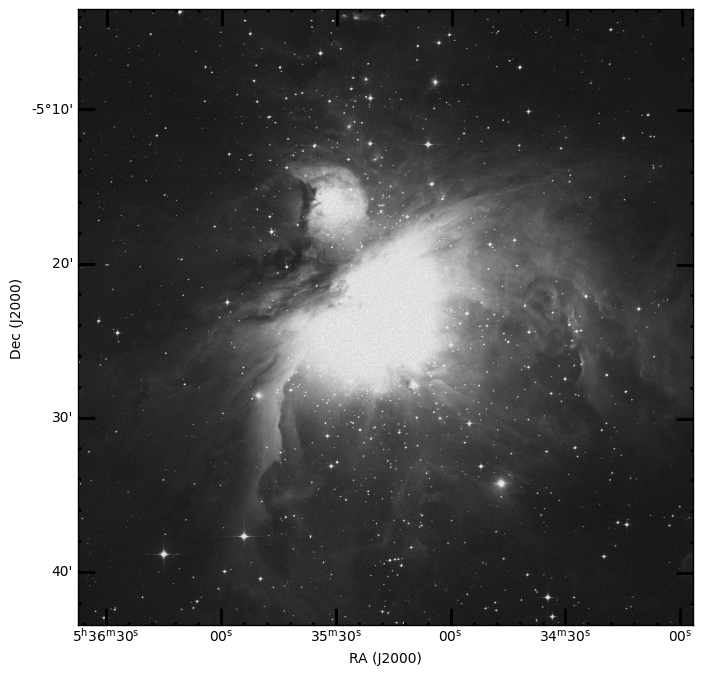

In [24]:
# plot composite red+IR image
fig = aplpy.FITSFigure(fits_files[0], figsize=(8,8)) #, downsample=300) ###remove downsample=300 for final plot
# make ticks prettier
fig.ticks.set_tick_direction('in')
fig.ticks.set_linewidth(2)
fig.ticks.set_length(12, 0.5)
fig.show_grayscale(aspect='equal')

# Download the Gaia DR3 data for this region

In [25]:
# check we use DR3
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"

In [26]:
# never download too many stars for testing, set to -1 for no limit, 6700 is enough to catch all the Gaia Data in Orion
Gaia.ROW_LIMIT = 100

In [27]:
# read the data
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')
print(gaiadr3_table)

TAP Table name: gaiadr3.gaiadr3.gaia_source
Description: This table has an entry for every Gaia observed source as published with this data release. It contains the basic source parameters, in their final state as processed by the Gaia Data Processing and Analysis Consortium from the raw data coming from the spacecraft. The table is complemented with others containing information specific to certain kinds of objects (e.g.~Solar--system objects, non--single stars, variables etc.) and value--added processing (e.g.~astrophysical parameters etc.). Further array data types (spectra, epoch measurements) are presented separately via Datalink resources.
Num. columns: 152


Retrieving table 'gaiadr3.gaia_source'


TAP Table name: gaiadr3.gaiadr3.gaia_source
Description: This table has an entry for every Gaia observed source as published with this data release. It contains the basic source parameters, in their final state as processed by the Gaia Data Processing and Analysis Consortium from the raw data coming from the spacecraft. The table is complemented with others containing information specific to certain kinds of objects (e.g.~Solar--system objects, non--single stars, variables etc.) and value--added processing (e.g.~astrophysical parameters etc.). Further array data types (spectra, epoch measurements) are presented separately via Datalink resources.
Num. columns: 152


In [28]:
# query data around Orion
Orion_center = SkyCoord(ra=orion_im_ra , dec=orion_im_dec, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(1.5, u.deg)
height = width
orion_cluster_all = Gaia.query_object_async(coordinate=Orion_center, width=width, height=height)

INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


## Filter out bad data
For more info see [Gaia collaboration
2022](https://ui.adsabs.harvard.edu/abs/2022arXiv220605595G/abstract) and citations to it.

In [29]:
print("Quality cuts:")
# renormilized unit weigh error
good_ruwe        = orion_cluster_all['ruwe'] < 1.4
print("Lost to good_ruwe",  np.sum(1-good_ruwe))
# excess astrometric noise
good_astro_noise = orion_cluster_all["astrometric_excess_noise"] < 1
print("Lost to good_astro_noise",  np.sum(1-good_astro_noise))
# visibility periods used for astrometric solution
good_vis         = orion_cluster_all['visibility_periods_used']>10
print("Lost to good_vis",  np.sum(1-good_vis))
# parallax relative error < 10%
good_parallax    = orion_cluster_all['parallax_over_error'] > 10
print("Lost to good_parallax",  np.sum(1-good_parallax))
# right parallax range, from, e.g. Kuhn et al. 2019
good_distance = (orion_cluster_all["parallax"] >= 2.2*u.mas) & (orion_cluster_all["parallax"]<= 2.7*u.mas)
print("Lost to distance",  np.sum(1-good_distance))
# combination
index_good       = good_ruwe & good_astro_noise & good_vis & good_parallax & good_distance
# verify number of stars left
print("-----------")
print("Of the initial", len(orion_cluster_all['ra']), "we retain only", len(orion_cluster_all['ra'][index_good]), "stars")

Quality cuts:
Lost to good_ruwe 13
Lost to good_astro_noise 47
Lost to good_vis 34
Lost to good_parallax 9
Lost to distance 22
-----------
Of the initial 100 we retain only 33 stars


## Visualize data

N.B: the Gaia data are in the `ICRS` frame (defined in the Gaia
documentation), the image is not, we would need to align things
properly.
For simplicity we assume the two frames are aligned

In [30]:
ra = orion_cluster_all["ra"]
ra_err = orion_cluster_all["ra_error"].to(u.degree)
dec = orion_cluster_all["dec"]
dec_err = orion_cluster_all["dec_error"].to(u.degree)

positions = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
ra_rad = positions.ra.wrap_at(180 * u.deg).radian
dec_rad = positions.dec.radian

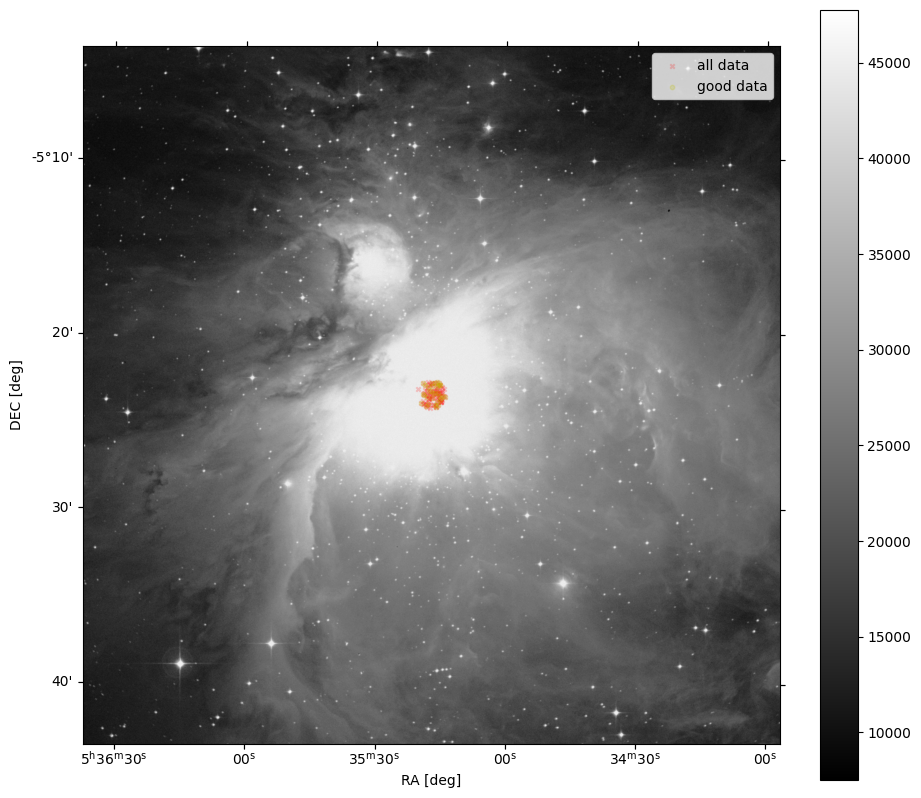

In [31]:
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(100, 100)
ax = fig.add_subplot(gs[:, :90], projection=wcs)
cax = fig.add_subplot(gs[:, 95:])

# read data
ra = orion_cluster_all["ra"]
dec = orion_cluster_all["dec"]
positions_icrs = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs') # in the Gaia frame
# get position in underlying image coordinates
x, y = wcs.all_world2pix(positions_icrs.ra.deg,positions_icrs.dec.deg, 0)

p = ax.imshow(stacked, cmap='gray')
# clip to composite image
ax.set_xlim(0, len(stacked[0]))
ax.set_ylim(0, len(stacked[1]))
# add colorbar
fig.colorbar(p, cax=cax)
# add data
ax.scatter(x, y, marker='x', c='r', s=10, zorder=10, alpha=0.2, label="all data")
ax.scatter(x[index_good], y[index_good], marker='o', c='y', s=10, zorder=10, alpha=0.2, label="good data")
ax.legend(frameon=True)
ax.set_xlabel(r"RA [deg]")
ax.set_ylabel(r"DEC [deg]")

## Visualize velocities!

In [32]:
# for c in orion_cluster_all.columns: print(c)

Text(0, 0.5, '$\\mu_\\mathrm{DEC} \\ [\\mathrm{mas\\ yr^{-1}}]$')

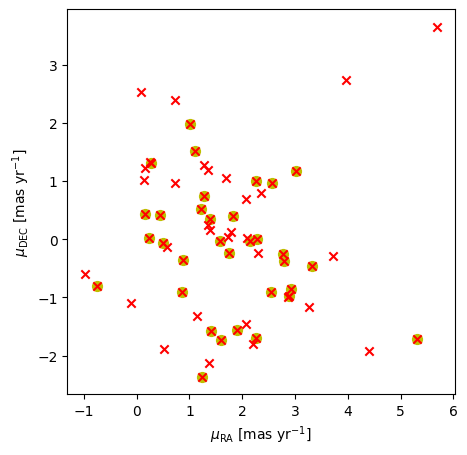

In [33]:
pmra = orion_cluster_all["pmra"]
pmdec = orion_cluster_all["pmdec"]
pmra_err = orion_cluster_all["pmra_error"]
pmdec_err = orion_cluster_all["pmdec_error"]
# print(min(pmdec), max(pmdec))
# check units!
# print(pmra.unit)
# print(pmra_err.unit)
# print(pmdec.unit)
# print(pmdec_err.unit)
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(100, 100)
ax = fig.add_subplot(gs[:, :])
ax.scatter(pmra, pmdec, c='r', marker='x', zorder=10)
ax.scatter(pmra[index_good], pmdec[index_good], marker='o', c='y', s=50)
ax.set_xlabel(r"$\mu_\mathrm{RA} \ [\mathrm{mas\ yr^{-1}}]$")
ax.set_ylabel(r"$\mu_\mathrm{DEC} \ [\mathrm{mas\ yr^{-1}}]$")

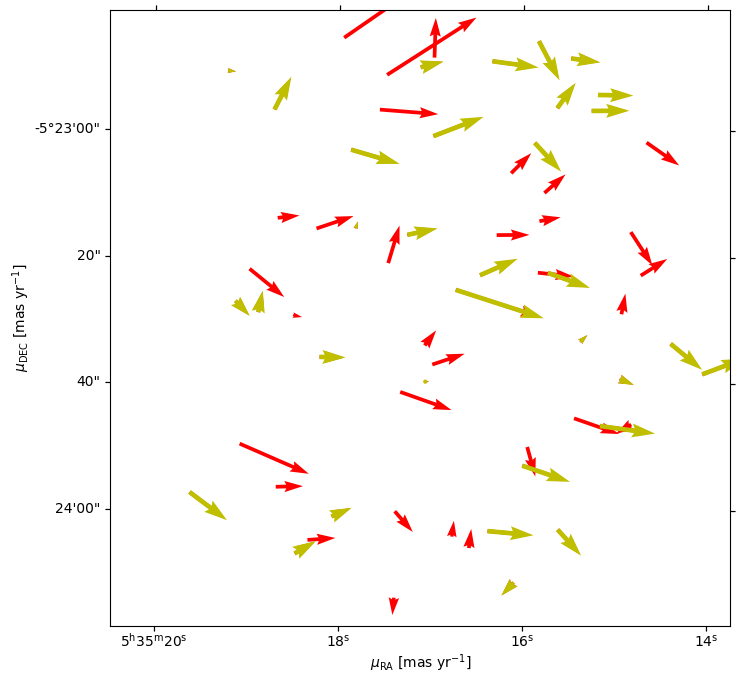

In [34]:
# visualize locations and velocities
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(100, 100)
ax = fig.add_subplot(gs[:, :], projection=wcs)
ax.quiver(x, y, pmra, pmdec, color='r')
ax.quiver(x[index_good], y[index_good], pmra[index_good], pmdec[index_good], color='y')
ax.set_xlabel(r"$\mu_\mathrm{RA} \ [\mathrm{mas\ yr^{-1}}]$")
ax.set_ylabel(r"$\mu_\mathrm{DEC} \ [\mathrm{mas\ yr^{-1}}]$")

### Define average motion of the cluster

We want to visualize the peculiar motion of the stars w.r.t. the
cluster, so we need to define and subtract the average motion of the
cluster.

For simplicity we will estimate the cluster proper motion with a
weighted mean of proper motions in the region, using 1/error^2 as the
weight. This does not properly account for possible correlations in
the errors in proper motions along the two directions (but Gaia
provides all the data to do the data analysis right!)


We also want to select only stars in a narrow region in the core (to
not bias our mean values with runaways and outliers)

1.7827060715808982 mas / yr 0.011862394087814827 mas / yr


Text(0, 0.5, 'Relative $\\mu_\\mathrm{DEC} \\ [\\mathrm{mas\\ yr^{-1}}]$')

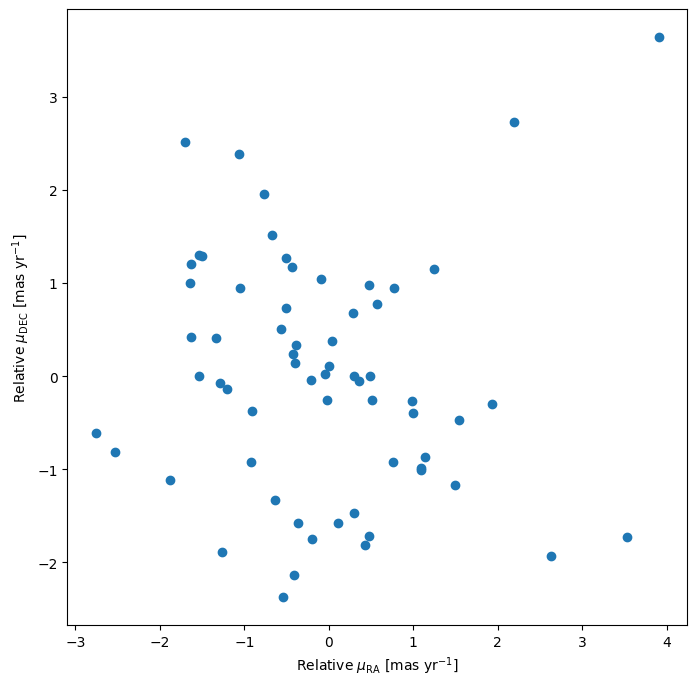

In [35]:
orion_pmra = np.average(pmra[index_good], weights=1./np.square(pmra_err[index_good]))
orion_pmdec = np.average(pmdec[index_good], weights=1./np.square(pmdec_err[index_good]))
print(orion_pmra *u.mas/u.yr, orion_pmdec *u.mas/u.yr)
# define relative proper motions
rel_pmra = pmra - orion_pmra
rel_pmdec = pmdec - orion_pmdec

fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(100, 100)
ax = fig.add_subplot(gs[:, :])
ax.scatter(rel_pmra, rel_pmdec)
ax.set_xlabel(r"Relative $\mu_\mathrm{RA} \ [\mathrm{mas\ yr^{-1}}]$")
ax.set_ylabel(r"Relative $\mu_\mathrm{DEC} \ [\mathrm{mas\ yr^{-1}}]$")



### Where in the sky are we looking?
See [astropy Skycoord docs](https://docs.astropy.org/en/stable/coordinates/skycoord.html)

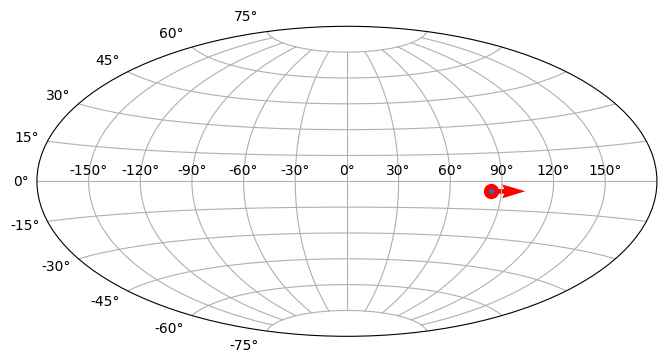

In [36]:
# see where in the Galaxy we are plotting things
fig = plt.figure(figsize=(8,4.2))
ax = fig.add_subplot(111, projection="aitoff")
ax.grid(True)
ax.plot(ra_rad, dec_rad, 'o', markersize=2, alpha=0.3)
ax.plot(orion_im_ra.to(u.radian), orion_im_dec.to(u.radian), markersize=10, zorder=0, c='r', marker='o')
ax.quiver(orion_im_ra.to(u.radian), orion_im_dec.to(u.radian), orion_pmra, orion_pmdec, color='r')

# Further exercises

*Suggestion*: try to visualize the disk structure of the Galaxy with a
similar plot (N.B.: may require downloading a large chunck of the DR3
catalog, remember to update `Gaia.ROW_LIMIT`)

In [37]:
# Limit number of stars!!
# Gaia.ROW_LIMIT = 10

# Gal_center = SkyCoord(ra=0, dec=0, unit=(u.degree, u.degree), frame='icrs')
# width = u.Quantity(359, u.deg)
# height = width
# MW_Galaxy = Gaia.query_object_async(coordinate=Gal_center, width=width, height=height)